# Introduction

The broad science goals of the Vera C. Rubin Observatory Legacy Survey of Space and Time (LSST) are to:

* Study the nature of dark matter and dark energy
* Catalog the Solar System
* Explore the changing sky
* Study Milky Way structure and formation

You can read more about these at the [LSST Website](https://www.lsst.org/science).

One technique that will be used to study dark matter and dark energy is gravitational lensing.  [Weak gravitational lensing](https://en.wikipedia.org/wiki/Weak_gravitational_lensing) refers to leads to the subtle distortion of the observed shapes of distant objects as their light interacts with a gravitational lens (a large concentration of matter such as a galaxy cluster or black hole that "bends" the path of light rays, much like a glass lens does in optics). This is in contrast with strong gravitational lensing, which describes extreme distortions by gravity that produce stunning images such as Einstein rings or crosses. The distortions caused by weak gravitational lensing are very small. Therefore care must be taken to make sure other sources of distortions to the observed galaxy shapes are addressed (and corrected for, when possible) first. 

One source of distortions that we are currently studying is the effect of "deferred charge". Deferred charge refers to the phenomena, where images appear to be "smeared" along rows or columns. A CCD is an array of pixels used to observe light; these pixels are then read-out one after the other by transferring the accumulated photo-electron charge in each pixel to a set of special electronics known as the output amplifier. During this transfer process some charge may be left behind, falling into one of its neighboring pixels.  This causes the "smearing" of the image.

## Notebook Description

This notebook is designed to get you started on studying the effect of deferred charge on the shapes of astronomical objects. The steps outlined are:

1. How to read a CCD image file.
2. How to perform some basic data reduction on an image.
3. How to identify and measure the properties of bright objects in an image.

We start by importing some Python tools (modules) that will be needed to perform some of the analysis.

In [9]:
## Include specific Python modules
import pickle
import numpy as np
from astropy.io import fits
from matplotlib import pyplot as plt

from lsst.eotest.sensor.spotTask import SpotTask, make_ccd_mosaic

# Constructing a Calibrated Image

The LSST Camera is still under construction, therefore it is impossible to point it at the sky and take pictures of galaxies and stars.  Instead we have a developed a way to take pictures of "fake stars" in the laboratory. During the previous testing period, some CCDs in the LSST Camera were illuminated, using a specially designed projector, with a grid of spots that resemble the size and shape of stars. We would like to use these images in order to study how similarly sized real astronomical objects might be stretched, shifted, or distorted. 

The first step is to produce a calibrated image, using a series of steps referred to as the data reduction process:

* Bias and overscan subtraction
* Gain correction
* Dark current subtraction

First, let's read in an image file and print the main header.  Our example image is from CCD on raft (or RTM) R02 and is CCD S02. These names refer to the position of the CCD and the raft in the focal plane.

In [2]:
infile = '../examples/data/R02_S02_spot_image.fits'

## Open the file
hdulist = fits.open(infile)
print(repr(hdulist[0].header))

SIMPLE  =                    T / Java FITS: Mon Oct 28 20:58:35 PDT 2019        
BITPIX  =                    8 / bits per data value                            
NAXIS   =                    0 / number of axes                                 
EXTEND  =                    T / Extensions are permitted                       
DATE    = '2019-10-31T11:51:13.820' / Creation Date and Time of File            
DATE-OBS= '2019-10-31T11:51:11.479' / Date of the image trigger (readout), UTC f
MJD     =    58787.49390995363 / Modified Julian Date that the file was written 
MJD-OBS =    58787.49388285866 / Modified Julian Date of image trigger          
RUNNUM  = '6865D   '           / The Run Number                                 
IMAGETAG= 'e8de8d3fd2d6c3b'    / DAQ Image id (Hex)                             
TSTAND  = 'BOT     '           / Camera test stand BOT or CCOB                  
INSTRUME= 'lsstCam '           / Instrument                                     
CONTNUM = '189223f9'        

The FITs file is read in as an `hdulist` object.  This is a list of `HDU` objects, each consisting of a `header` and `data`.  The first `HDU` is just a `header` (above) and no `data`, containing information about the image testing conditions and the CCD sensor used.  

LSST CCDs are not a single large 4000x4000 sensor with one output amplifier; instead they are split into 16 segments, each with its own amplifier.  This allows one to read out all of the pixels 16x faster.

The next 16 `hdu` in the `hdulist` correspond to each of the 16 segments that contain specific segment information in their headers, and a corresponding segment image. Let's use `matplotlib` to plot an image of one of the segments.

Text(0.5, 0, 'Pixel')

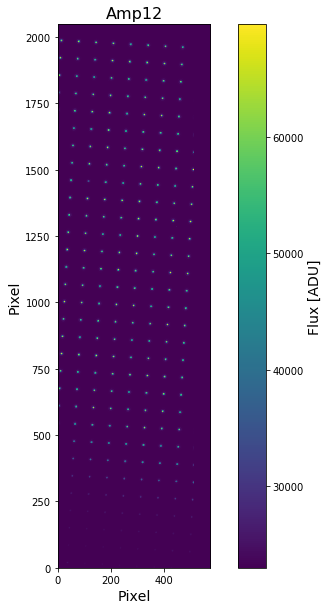

In [10]:
## Select segment to plot, in this case the segment with output amp number 12.
amp_num = 12
amp_image = hdulist[amp_num].data

## Set-up a blank plot and set of y/x axes
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

## Plot an image
cax = ax.imshow(amp_image, origin='lower')

## Set up a colorbar and a label
cbar = fig.colorbar(cax)
cbar.set_label('Flux [ADU]', fontsize=14)

## Label the plot
ax.set_title('Amp{0}'.format(amp_num), fontsize=16) # The syntax here is Python 'string formatting'
ax.set_ylabel('Pixel', fontsize=14)
ax.set_xlabel('Pixel', fontsize=14)

The signal is reported in "ADU" or analog-digital-units.  These can be thought of as unit-less counts.  For most of our studies we are interested in the signal level in "electrons".  To convert from ADU to electrons, you will need to know the conversion factor, or "gain", which has units of electrons/ADU.  Each of the 16 amplifiers will have a unique gain that will be needed to properly combine them into a single image.

To get a full CCD image, we'll need to take all the amplifiers and put them together into a single array.  Additionally, we can perform the calibration steps by including a `bias_frame`, a `dark_frame`, and a file containing information about the `gain` for each segment..

The machinery that performs the above operations is nicely wrapped into the single function `make_ccd_mosaic()`.

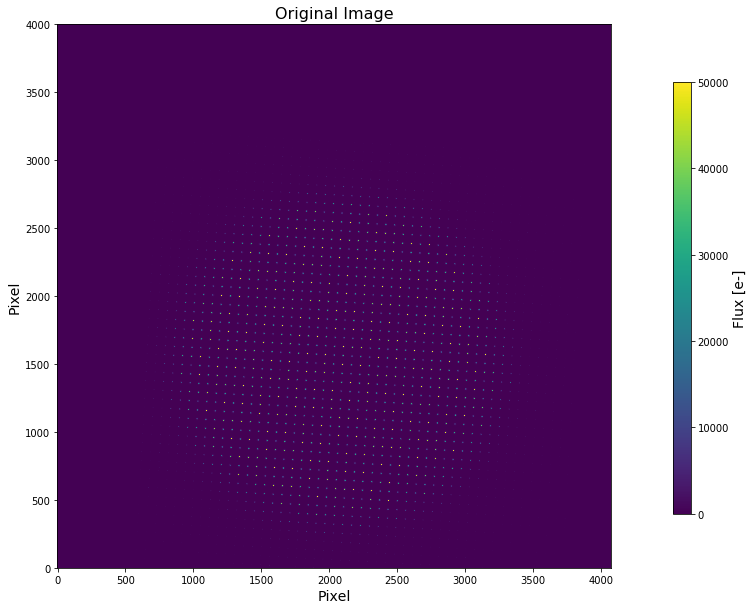

In [16]:
## Get an image file
infile = '../examples/data/R02_S02_spot_image.fits'

## Get superdark file
dark_frame = '../examples/data/R02_S02_superdark.fits'

## Get a superbias file
bias_frame = '../examples/data/R02_S02_superbias.fits'

## Get a file of gain results
gain_results_file = '../examples/data/et_results.pkl'

## A fancy way of opening the gain file
with open(gain_results_file, 'rb') as f:
    gain_results = pickle.load(f)
    gains = gain_results.get_amp_gains('R02_S02') # This gives you a 'dictionary' of gain results

## Run make_ccd_mosaic with all our calibration items
ccd_image = make_ccd_mosaic(infile, bias_frame=bias_frame, dark_frame=dark_frame, gains=gains)

## Get image array
imarr = ccd_image.getArray()

## Plot images side-by-side
fig, ax = plt.subplots(1, 1, figsize=(12, 10), sharey=True)
im0 = ax.imshow(imarr, origin='lower', vmin=10, vmax = 50000.)
ax.set_ylabel('Pixel', fontsize=14)
ax.set_xlabel('Pixel', fontsize=14)
ax.set_title('Original Image', fontsize=16)

## Add a global colorbar
fig.subplots_adjust(right=0.89)
cbar_ax = fig.add_axes([0.9, 0.2, 0.02, 0.6])
cbar = fig.colorbar(im0, cax=cbar_ax)
cbar.set_label('Flux [e-]', fontsize=14)

## Identifying and Measuring Objects

As can be seen in the image created in the preceding section, there are a number of bright "fake stars" in the image. The next step is to find the exact position of each one and measure some properties of it (such as high bright it is).  The LSST software has a number of functions that can performs this for you!

In particular there is an analysis task known as the `SpotTask`, designed to find the bright spots.  Let's try it out.

In [18]:
## Set up the task and configure some settings
spottask = SpotTask()
spottask.config.verbose = False
spottask.config.output_dir = '../examples/data/'
spottask.config.characterize_minpixels = 2
spottask.config.characterize_nsig = 4
spottask.config.calibrate_minpixels = 4
spottask.config.characterize_nsig = 25
spottask.config.output_file = 'R02_S02_source_catalog.cat'
spottask.config.verbose = True

## Now run the task
spottask.run('R02_S02', infile, gains, bias_frame=bias_frame, dark_frame=dark_frame)

Now let's take a look at what the results are, by opening up the catalog that was created by the `SpotTask`.

In [20]:
catalog = '../examples/data/R02_S02_source_catalog.cat'

## Print the column names
src = fits.getdata(catalog)
print(src.columns)

ColDefs(
    name = 'flags'; format = '97X'
    name = 'id'; format = '1K'
    name = 'coord_ra'; format = '1D'; unit = 'rad'
    name = 'coord_dec'; format = '1D'; unit = 'rad'
    name = 'parent'; format = '1K'
    name = 'base_NaiveCentroid_x'; format = '1D'; unit = 'pixel'
    name = 'base_NaiveCentroid_y'; format = '1D'; unit = 'pixel'
    name = 'base_SdssCentroid_x'; format = '1D'; unit = 'pixel'
    name = 'base_SdssCentroid_y'; format = '1D'; unit = 'pixel'
    name = 'base_SdssCentroid_xErr'; format = '1E'; unit = 'pixel'
    name = 'base_SdssCentroid_yErr'; format = '1E'; unit = 'pixel'
    name = 'base_Blendedness_old'; format = '1D'
    name = 'base_Blendedness_raw'; format = '1D'
    name = 'base_Blendedness_raw_child_instFlux'; format = '1D'; unit = 'count'
    name = 'base_Blendedness_raw_parent_instFlux'; format = '1D'; unit = 'count'
    name = 'base_Blendedness_abs'; format = '1D'
    name = 'base_Blendedness_abs_child_instFlux'; format = '1D'; unit = 'count'
    nam

The results are a file containing a large table with the following columns associated with different properties of each of the spots that were identified in the image. 

To get an idea of what these results are lets plot a scatter plot of the X/Y positions of all the spots that were found. In addition we can color the plotted points to correspond with how bright the spots are.

We can also overlay the CCD geometry, to show where the spots are in relation to the different segments of the CCD.

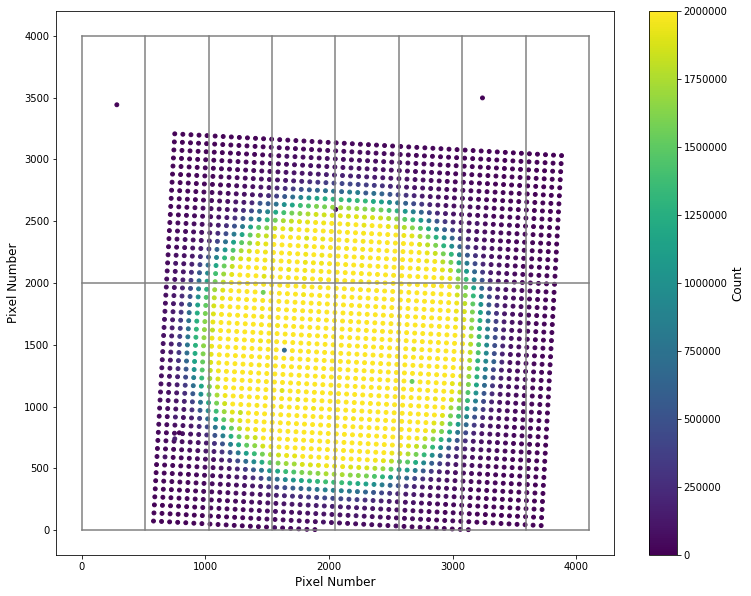

In [22]:
## Get x/y/z arrays from the source catalog.
X = src['base_SdssShape_x']
Y = src['base_SdssShape_y']
Z = src['base_SdssShape_instFlux'] # one of the many ways of measuring how bright the spot is

## Scatter plot x/y positions and flux value as the color parameter
fig, ax = plt.subplots(1, 1, figsize=(12.5, 10))
cax = ax.scatter(X, Y, c=Z, marker='o', s=15, vmin=0.0, vmax=2000000.)
ax.set_ylabel('Pixel Number', fontsize=12)
ax.set_xlabel('Pixel Number', fontsize=12)
cbar = fig.colorbar(cax)
cbar.set_label('Count', fontsize=12)

## Plot the CCD amplifier geometry (for an ITL sensor)
for i in range(3):
    ax.plot(np.asarray([0, 513*8]), np.asarray([i*2000, i*2000]), 'grey')
for i in range(9):
    ax.plot(np.asarray([513*i, 513*i]), np.asarray([0, 4000]), 'grey')

Comparing this to the CCD image plotted early, most notably, there were even a bunch of spots that were too bright to see in the original image! This is due to the limits used for the color bar (you can play with them to see if you can get the dim spots to be visible, if you like). 

While in the above plot, we looked at the fluxes of each spot, if you are interested in what the shapes of the spots are, then the Table columns name `base_SdssShape_xx`, `base_SdssShape_yy`, and `base_SdssShape_xy` will be very useful.

Where is X/Y referred to the position of each spot, XX/YY refer to the [moments](https://en.wikipedia.org/wiki/Moment_(mathematics)) of the spot, a manner to quantify the width of the spots along the X and Y directions.